Testing stuff out from the gate

In [1]:
!curl -X GET "https://api.socialdata.tools/twitter/statuses/show?id=1740192018918170738" \
-H "Accept: application/json" \
-H "Authorization: Bearer 539|UUzjs2bbjYLuc4cACbztsBRnIv7y5xHufiZYwDuoa9058562"

{"status":"error","message":"Insufficient balance"}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100    51    0    51    0     0     26      0 --:--:--  0:00:01 --:--:--    26


Creating a Function that uses the search endpoint and creates a Dataframe out of it.

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Social Data API endpoint and your API key
API_ENDPOINT = "https://api.socialdata.tools/twitter/search"
API_KEY = "574|9dLEGFBiWHWnFsZj04Tx5fflaBFJEgJqLq7PTedh7a138543"

def fetch_tweets(keywords, start_date, end_date, limit=1000):
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    params = {
        "query": " OR ".join(keywords)+ " AND news",
        "type": "Top",
        "limit": limit,
    }

    response = requests.get(API_ENDPOINT, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error fetching tweets: {response.status_code} - {response.text}")

def process_tweets(tweets_data):
    processed_tweets = []
    for tweet in tweets_data['tweets']:
        processed_tweets.append({
            'created_at': tweet['tweet_created_at'],
            'text': tweet['full_text'],
            'username': tweet['user']['screen_name'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count'],
            'media_url': tweet['entities']['media'][0]['media_url_https'] if 'media' in tweet['entities'] else None
        })
    return processed_tweets

# Main execution
if __name__ == "__main__":
    # Set up search parameters
    keywords = ["bitcoin", "ethereum", "cryptocurrency", "crypto"]
    start_date = datetime.now() - timedelta(days=10)  # Last 7 days
    end_date = datetime.now()

    # Fetch tweets
    raw_tweets = fetch_tweets(keywords, start_date, end_date)

    # Process tweets
    processed_tweets = process_tweets(raw_tweets)

    # Convert to DataFrame
    df = pd.DataFrame(processed_tweets)

    # Save to CSV
    csv_filename = 'cryptocurrency_tweets.csv'
    df.to_csv(csv_filename, index=False)

    print(f"Extracted {len(df)} tweets about cryptocurrency.")
    print(f"Data saved to '{csv_filename}'")

    # Display first few rows
    df.head()

Exception: Error fetching tweets: 402 - {"status":"error","message":"Insufficient balance"}

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

## Key Points to notice

- We cant sort by top posts cuz most of these are giveaway/promotional posts that provide us no information about the news and updates (This will be figured by putting better queries)
- We can only search 20 posts at a time. I tried using more using this endpoint [POST https://api.socialdata.tools/twitter/search/asyncJob](https://api.socialdata.tools/twitter/search/asyncJob) but it immediately drained my account balance.
- Most of the output is in Other languages too. We must filter out languages other than english.

Running Cryptobert on these datasets

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

tokenizer = BertTokenizer.from_pretrained("kk08/CryptoBERT")
model = BertForSequenceClassification.from_pretrained("kk08/CryptoBERT")

In [ ]:


classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
for text in df['text']:
  result = classifier(text)
  print(result)



Now Getting News using News API

In [ ]:
!pip install newsapi-python

In [ ]:
from newsapi import NewsApiClient

# Init
newsapi = NewsApiClient(api_key='4670c278aa53490b99c29e290984acd4')
# /v2/everything
all_articles = newsapi.get_everything(q='bitcoin OR ethereum',
                                      sources='bbc-news,the-verge',
                                      domains='bbc.co.uk,techcrunch.com',
                                      from_param= datetime.now()-timedelta(days=10),
                                      to=datetime.now(),
                                      language='en',
                                      sort_by='relevancy',
                                      page=2)


all_articles

In [9]:
bruh= requests.get(f"https://newsapi.org/v2/everything?q=cryptocurrency OR bitcoin OR ethereum OR blockchain&from={datetime.now()-timedelta(days=10)}&to={datetime.now}&sortBy=popularity&language=en&apiKey=4670c278aa53490b99c29e290984acd4")

In [ ]:
bruh.json()

In [ ]:
df_news = pd.json_normalize(bruh.json()['articles'])
df_news


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_news)

### Keyword and Langchain

In [ ]:
!pip install groq langchain-groq langchain langchain_core

In [14]:
import os
from google.colab import userdata


This one is using the groq libary directly

In [ ]:
from groq import Groq
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()
client = Groq(api_key=userdata.get('GROQ_API_KEY'))
completion = client.chat.completions.create(
    model="llama3-groq-70b-8192-tool-use-preview",
    messages=[
        {
            "role": "system",
            "content": "JSON You are a bot whose job is to take Crypto News put it in the category of the top 50 cryptocurrencies of the world, the list is:\nBitcoin\nEthereum\nTether USD\nBNB\nSolana\nUSDC\nXRP\nLido Staked Ether\nToncoin\nDogecoin\nCardano\nTRON\nWrapped liquid staked Ether 2.0\nWrapped BTC\nAvalanche\nShiba Inu\nWrapped Ether\nPolkadot\nBitcoin Cash\nChainlink\nDai\nUniswap\nLitecoin\nPolygon\nBinance-Peg BSC-USD\nKaspa\nWrapped eETH\nInternet Computer (DFINITY)\nPEPE\nUSDe\nEthereum Classic\nMonero\nPancakeSwap\nAptos\nNEAR Protocol\nImmutable X\nFetch.AI\nOKB\nStacks\nFilecoin\nBittensor\nStellar\nFirst Digital USD\nMantle\nHedera\nVeChain\nWhiteBIT Coin\nRender Token\nEnergySwap\nMaker\n\nUnless a new Cryptocurrency is mentioned (with its code) always put the articles in these list. If the news is general and not applicable to any cryptocurrency You can also mark the Article as general.\nExample:\n\nDogecoin (DOGE) currently holds a market capitalization of $19  billion. Despite experiencing a 14% price surge over the past two weeks, the cryptocurrency remains significantly below its all-time hi… [+4205 chars]\n\nCryptocurrencies: Dogecoin\n\nExperts predict that Toshi, one of the most popular Base meme coins, could go up by 10x this year because of the recent surge in meme coins.\nThis article explores the recent developments, features, … [+5097 chars]\n\nCryptocurrencies: TOSHI\n\nExperts predict a big surge for Pepe (PEPE), leading many investors to believe now is the best time to buy in.\nThe cryptocurrency market is on the rise. Market volume has jumped by 62%, and the Fear… [+5122 chars]\n\nCryptocurrencies: PEPE\n\nWith $45.5 million in corporate contributions, American cryptocurrency exchange Coinbase is the largest donor to Fairshake: a newly-minted super PAC focused solely on installing political candidates … [+10647 chars]\n\nCryptocurrencies: General\n\n"
        },
        {
            "role": "user",
            "content": "With Bitcoin (BTC) surging and the market exhibiting greed according to the Fear and Greed Index, it’s an opportune time to consider diversifying your portfolio with altcoin investments.\nWhile meme … [+6891 chars]"
        }
    ],
    temperature=0.5,
    max_tokens=1024,
    top_p=0.65,
    stream=False,
    response_format={"type": "json_object"},
    stop=None,
)

print(completion.choices[0].message.content)


In [16]:
top_cryptos = [
    "Bitcoin", "Ethereum", "Tether USD", "BNB", "Solana", "USDC", "XRP", "Lido Staked Ether",
    "Toncoin", "Dogecoin", "Cardano", "TRON", "Wrapped liquid staked Ether 2.0", "Wrapped BTC",
    "Avalanche", "Shiba Inu", "Wrapped Ether", "Polkadot", "Bitcoin Cash", "Chainlink", "Dai",
    "Uniswap", "Litecoin", "Polygon", "Binance-Peg BSC-USD", "Kaspa", "Wrapped eETH",
    "Internet Computer (DFINITY)", "PEPE", "USDe", "Ethereum Classic", "Monero", "PancakeSwap",
    "Aptos", "NEAR Protocol", "Immutable X", "Fetch.AI", "OKB", "Stacks", "Filecoin", "Bittensor",
    "Stellar", "First Digital USD", "Mantle", "Hedera", "VeChain", "WhiteBIT Coin", "Render Token",
    "EnergySwap", "Maker",'BRETT', 'The Doge NFT', 'DEGEN', 'TOSHI', 'doginme', 'Normie',
    'OmniCat', 'Marvin', 'RealGOAT', 'Mister Miggles', 'Basenji',
    'UPSIDE DOWN MEME', 'SPX6900', '$MFER', 'ChompCoin', 'SKOP Token',
    'Marso.Tech', 'Keyboard Cat', 'higher', 'donotfomoew', 'Pepe',
    'Base God', 'Crash', 'BORED', 'Roost Coin', 'BUILD', 'FomoBullClub',
    'Noggles', 'All Street Bets', 'WASSIE', 'DINO', 'Moby', 'Mamba',
    'Shoobadookie', 'Based Street Bets', 'Ski Mask Dog', 'AEROBUD',
    'Fungi', 'FOMO_BASE', 'ROCKY', 'Rug World Assets', 'BlockChainPeople',
    'Apedinbase', 'GameStop on Base', 'Based Shiba Inu', 'Misser',
    'Father Of Meme: Origin', 'Katt Daddy', 'Heroes of memes', 'DERP'
]

prompt = PromptTemplate(
    input_variables=["text"],
    template="""
        Given the following text:
        {text}

        Identify any cryptocurrencies mentioned in the text and categorize them as 'crypto'. If no cryptocurrencies are found, categorize the text as 'general'.

        The response should be a list of dictionaries with the following format:
        [
            {{
                "name": "Bitcoin",
                "category": "crypto"
            }},
            {{
                "name": "Ethereum",
                "category": "crypto"
            }},
            {{
                "name": "This text is not about any specific cryptocurrencies",
                "category": "general"
            }}
        ]
    """
)

In [17]:
from langchain_groq import ChatGroq


In [18]:
from typing import List, Tuple
def crypto_categorizer(text: str) -> List[dict]:
    llm = ChatGroq(groq_api_key = userdata.get('GROQ_API_KEY'),model = "llama3-groq-70b-8192-tool-use-preview")
    #chain = LLMChain(prompt=prompt, llm=llm)
    chain = prompt | llm | parser
    result = chain.invoke(text)
    return eval(result)

### Using langchain to make our thing

Prompt Template

In [42]:
def get_sentiment(news_articles):
  """
  Given the news article, returns the Sentiment Analysis Score on the Text """
  classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
  classy=classifier(news_articles)
  if classy[0]['label']=="LABEL_1":
    sentiment="Positive"
  else:
    sentiment="Negative"
  prompt = PromptTemplate(
    input_variables=["news_articles","sentiment"],
    template="""

        You are an expert in Cryptocurrency and have tons of experience in the analysis and speculations in the crypto market. You are given the follwing news article:
        {news_articles}

        We are getting the following sentiment from this article:
        {sentiment}

        In your expert knowledge in this field, explain why there could be this given sentiment:
    """
)
  llm = ChatGroq(groq_api_key = userdata.get('GROQ_API_KEY'),model = "llama3-groq-70b-8192-tool-use-preview")
  chain = prompt | llm | parser
  result = chain.invoke({"news_articles":news_articles,"sentiment":sentiment})


  return f"{sentiment} {classy[0]['score']} \n Here is why: \n {result}"


In [ ]:
text = "JUST IN: 🇷🇺 President Putin signs law legalizing cryptocurrency mining in Russia. https://t.co/GqpcmFTqDR"
categories = crypto_categorizer(text)
for category in categories:
    print(f"{category['name']} - {category['category']}")

Explaining the Sentiment using Groq.

In [ ]:
query = """
🚨BREAKING: MAJOR BLACK SWAN EVENT IS HAPPENING!!

XRP and CTF Token suddenly are priced at $198.53 for minutes on CMC.

Trading has been Halted on Multiple Crypto exchanges.

CryptoTradingFund Token (https://t.co/Vw93uDoegt) on the XRP Ledger has also begun Skyrocketing, Has the BULLRUN STARTED?!"""

get_sentiment(query)

## Doing Agentic functions using langgraph

In [ ]:
!pip install langgraph langchain-community

In [3]:
from langchain_community.document_loaders.directory import DirectoryLoader
from langchain_community.document_loaders.csv_loader import CSVLoader
loader = DirectoryLoader(path="crypto_data/", loader_cls=CSVLoader)
data = loader.load()

len(data)


2764

In [4]:
data[0]

Document(metadata={'source': 'crypto_data\\AAVE_ohlcv.csv', 'row': 0}, page_content='timestamp: 2024-08-04\nopen: 105.52\nhigh: 112.0\nlow: 96.891\nclose: 97.159\nvolume: 39024.56411935')

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
docs = text_splitter.split_documents(data)


docs[-1]

Document(metadata={'source': 'crypto_data\\XRP_ohlcv.csv', 'row': 59}, page_content='timestamp: 2024-10-02\nopen: 0.5968\nhigh: 0.607\nlow: 0.57625\nclose: 0.58371\nvolume: 15789673.8718')

In [6]:

from langchain_community.vectorstores import Chroma


vectorstore = Chroma.from_documents(
    documents=docs,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

: 

In [5]:
retriever.invoke("What is the Closing price of BTC in 2nd October?")

NameError: name 'retriever' is not defined

In [57]:
!pip install duckduckgo-search

In [13]:
# Creating Custom Retriever Function
from langchain_core.tools import tool
import ccxt
import pandas as pd
from datetime import date
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
exchange = ccxt.kucoin()
date=date.today()
@tool
def ohlcv_tool(query:str):
    """Converts the query string into its Cryptocurrency symbol to search the OHLCV data and returns its associated market data"""
    symbol = f"{query}/USDT"
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', limit=30)
    return ohlcv

@tool
def ddgs_tool(query:str):
    """Returns the search results from DuckDuckGo search engine"""
    
    #wrapper = DuckDuckGoSearchAPIWrapper(region="de-de", time="d", max_results=2)

    search = DuckDuckGoSearchResults(backend="news")

    return search.invoke(query)

    


Note: you may need to restart the kernel to use updated packages.


In [14]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
"""retriever_tool = create_retriever_tool(
    retriever,
    "retriever_ohlcv_data",
    "Search and retrieve the OHLCV Market Data of the top 50 cryptocurrencies.",
)"""

tools = [ddgs_tool, ohlcv_tool]

In [15]:
from typing import Annotated, Literal, TypedDict
from IPython.display import Image, display
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

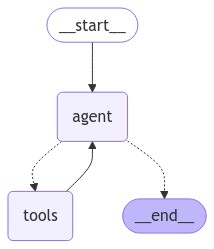

In [16]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [17]:
model.invoke("what is XRP's looking?").tool_calls

[{'name': 'ohlcv_tool',
  'args': {'query': 'XRP'},
  'id': 'call_DHeMNoUR0dmRzJavJEhBfkL2',
  'type': 'tool_call'}]

In [18]:
app.invoke({"messages": [("human", "How is bitcoin's latest market data looking on 2nd October and How are the news supporting the data?")]},config={"configurable": {"thread_id": 42}})

{'messages': [HumanMessage(content="How is bitcoin's latest market data looking on 2nd October and How are the news supporting the data?", additional_kwargs={}, response_metadata={}, id='8c8304b7-d155-400b-aec4-c71279c07c3b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M3TL1agvMFlcGN7gjtzHwnJ2', 'function': {'arguments': '{"query": "bitcoin"}', 'name': 'ohlcv_tool'}, 'type': 'function'}, {'id': 'call_owXolnN9Cow6xsDSxEK5QMO1', 'function': {'arguments': '{"query": "bitcoin news October 2 2023"}', 'name': 'ddgs_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 109, 'total_tokens': 163, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cd5539b4-70cf-4afa-ade7

In [ ]:
for chunk in app.stream(
    {"messages": [("human", "How is bitcoin's latest market data looking on 2nd October and How are the news supporting the data?")]}, stream_mode="values",
    config={"configurable": {"thread_id": 1}}
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

How is bitcoin's latest market data looking on 2nd October and How are the news supporting the data?
================================== Ai Message ==================================
Tool Calls:
  ohlcv_tool (call_utGZLe8ZXfuUixJkkTqYNdR4)
 Call ID: call_utGZLe8ZXfuUixJkkTqYNdR4
  Args:
    query: BTC
  ddgs_tool (call_74fkbjJZCydq1wWxCDWbg0fv)
 Call ID: call_74fkbjJZCydq1wWxCDWbg0fv
  Args:
    query: bitcoin news October 2 2023
================================= Tool Message =================================
Name: ddgs_tool

Error: RatelimitException('https://duckduckgo.com/ 202 Ratelimit')
 Please fix your mistakes.
================================== Ai Message ==================================

### Bitcoin's Market Data on October 2, 2023

On October 2, 2023, Bitcoin (BTC) experienced the following market activity:

- **Opening Price**: $60,307.80
- **Highest Price**: $61,777.00
- **Lowest Price**: $59

In [12]:
%pip install --upgrade --quiet duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
